In [1]:
# AI model to classify space rocks
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn, optim
from torch.autograd import Variable
import torch.nn.functional as F
import torchvision
from torchvision import datasets, transforms, models
from PIL import Image


In [2]:
#  libraries that ensure that paths are displayed inserted and in high resolution
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [3]:
# contains the image data
data_dir = './Data'

# Read the data, crop and resize the images, 
# split data into two groups: test and train
def load_split_train_test(data_dir, valid_size = .2):

    # Transform the images to train the model
    train_transforms = transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.Resize(224),
        transforms.ToTensor(),    
        ])
    
    # Transform the images to test model
    test_transforms = transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.Resize(224),
        transforms.ToTensor(),
    ])

    # Create two variables for the folders with the training and testing images
    train_data = datasets.ImageFolder(data_dir, transform=train_transforms)
    test_data = datasets.ImageFolder(data_dir, transform=test_transforms)

    # Get the number of images in the training folder
    num_train = len(train_data)

    # Create a list 
    indices = list(range(num_train))

    # If valid_size is .2, find the index of the image that represents 20% of the data
    # If there are 10 images, a split would result in 2
    # split = int(np.floor(.2 * 10)) -> int(np.floor(2)) -> int(2) -> 2
    split = int(np.floor(valid_size * num_train))

    # Random shuffle the indices
    # For 10 images, an example would be that indices is now the list [2,5,4,6,7,1,3,0,9,8]
    np.random.shuffle(indices)

    from torch.utils.data.sampler import SubsetRandomSampler

    # With the indices randomly shuffled, 
    # grab the first 20% of the shuffled indices, and store them in the training index list
    # grab the remainder of the shuffled indices, and store them in the testing index list
    # Given our example so far, this would result is:
    # train_idx is the list [1,5] 
    # test_idx is the list [4,6,7,1,3,0,9,8]
    train_idx, test_idx = indices[split:], indices[:split]

    # Create samplers to randomly grab items from the training and testing indices list
    train_sampler = SubsetRandomSampler(train_idx)
    test_sampler = SubsetRandomSampler(test_idx)

    # Create loaders to load 16 images from the train an test data folders
    # Images are choosen based on the shuffled index lists and by using the samplers
    trainloader = torch.utils.data.DataLoader(train_data, sampler=train_sampler, batch_size=16)
    testloader = torch.utils.data.DataLoader(test_data, sampler=test_sampler, batch_size=16)

    return trainloader, testloader


# Using the function that shuffles images,
# create a trainloader to load 20% of the images
# create a testloader to load 80% of the images
trainloader, testloader = load_split_train_test(data_dir, .2)

print(trainloader.dataset.classes)
# print(testloader.dataset.classes)


['Basalt', 'Highland']


## Adding code to transform and select random images

In [4]:


# Transform an image into pixels and resize it
test_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.Resize(224),
    transforms.ToTensor(),
])

# Randomly select a set of images by using a similar approach as the load_split_train_test function
def get_random_images(num):
    data = datasets.ImageFolder(data_dir, transform=test_transforms)
    classes = data.classes
    indices = list(range(len(data)))
    np.random.shuffle(indices)
    idx = indices[:num]

    from torch.utils.data.sampler import SubsetRandomSampler

    sampler = SubsetRandomSampler(idx)
    loader = torch.utils.data.DataLoader(data, sampler=sampler, batch_size=num)

    # Create an iterator to iterarte over the shuffled images in the test images dataset
    dataiter = iter(loader)

    # Get and return the images and labels from the iterator
    images, labels = dataiter.next()

    return images, labels


## Adding code to display randomly selected images

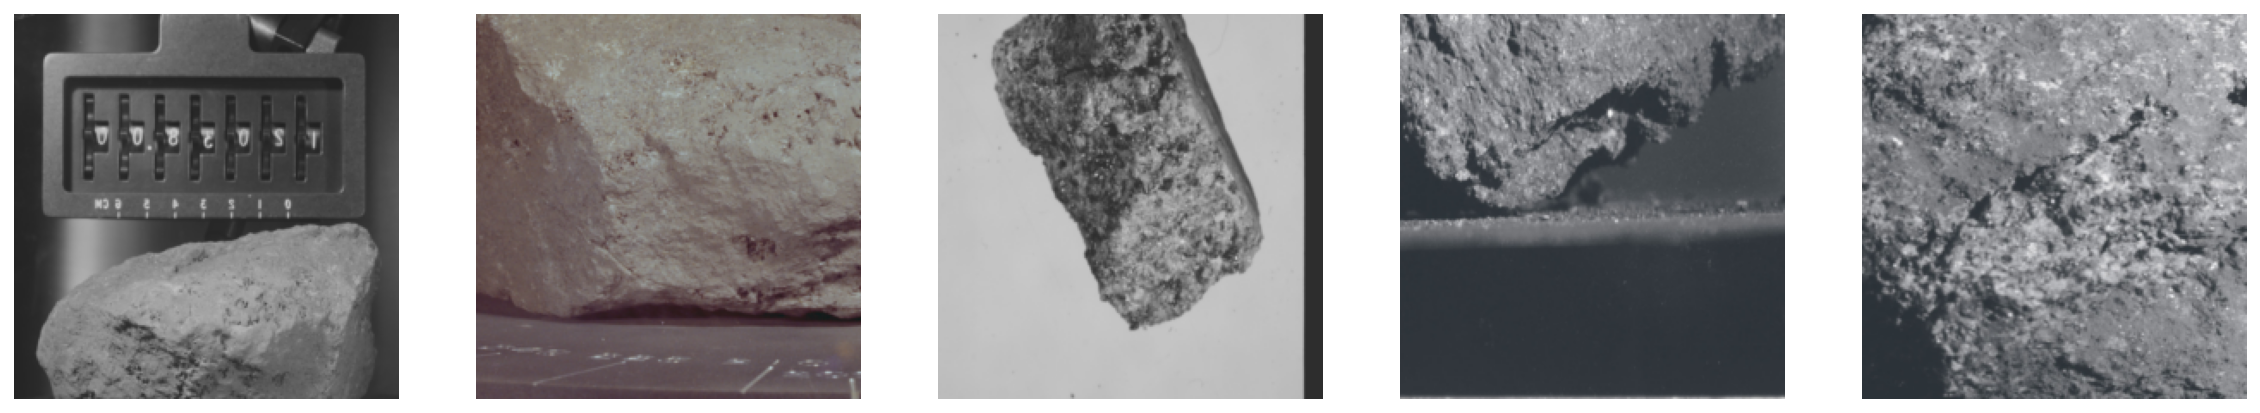

In [5]:


# Show five images 
images, labels = get_random_images(5)

# Convert the array of pixels to an image
to_pil = transforms.ToPILImage()
fig = plt.figure(figsize=(20, 20))

# Get a list of all classes in the training data
classes = trainloader.dataset.classes

# Draw the images in a plot to display in the notebook

for ii in range(len(images)):
    image = to_pil(images[ii])
    sub = fig.add_subplot(1, len(images), ii+1)
    plt.axis('off')
    plt.imshow(image)

# Display all of the images
plt.show()

In [6]:
# Determine if you're using a CPU or a GPU device to build the deep learning network
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.resnet50(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to C:\Users\vanit/.cache\torch\hub\checkpoints\resnet50-0676ba61.pth
100.0%


## Creation of neurons and connection of the network

In [7]:
# Build all the neurons
for param in model.parameters():
    param.requires_grad = False

# Wire the neurons together to create the neural network
model.fc = nn.Sequential(
    nn.Linear(2048, 512), 
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(512, 2),
    nn.LogSoftmax(dim=1)
    )

criterion = nn.NLLLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.003)

# Add the neural network to the device
model.to(device)

print("done")


done
